## Cocontraction analysis

To do:
- [ ] only read in data from actual trial (now data from before and after is also read in)
- [ ] do actual analysis on cocontraction

In [1]:
# load packages

import os
import h5py
import pandas as pd
import numpy as np

In [2]:
# define style for figures
import seaborn as sns
sns.set()
sns.set_style("white")
sns.set_context("talk")

In [9]:
# Read in tracking data
current_directory = os.getcwd()

data = np.empty((0,10))
# data = np.empty((0,8))

# participants
# Sigrid: only up to SN10 on this computer, Sarah: change to include all participatns
participants = ('SN001', 'SN002', 'SN003', 'SN004', 'SN005', 'SN006', 'SN007', 'SN008', 'SN009', 'SN010', 'SN011', 'SN012', 'SN013', 'SN014', 'SN015', 'SN016', 'SN018', 'SN019', 'SN020', 'SN021')

SN = 0
for p in participants:
    SN = SN + 1
    # find folders with tracking data
    root_subject = os.path.join('data', p)
    root_subject = os.path.join('data', p)
    control_folders = [f.path for f in os.scandir(root_subject) if f.is_dir() and f.name.startswith('control')]
    BN = 0
    for b in control_folders:
        BN = BN + 1
        if os.path.isfile(os.path.join(b, 'trials.csv')):
            # only include blocks with emg tracking
            trials = pd.read_csv(os.path.join(b, 'trials.csv'))

            if trials["emg"][0] == 1:
                if os.path.isfile(os.path.join(b, 'data_proc.hdf5')):
                    data_proc = h5py.File(os.path.join(b, 'data_proc.hdf5'), 'r')
                    n_total_trials = trials.shape[0]
                    
                    for t in range(n_total_trials)  :
                        data_trial = data_proc.get(str(t))[()].T
                        sn_array = np.ones((data_trial.shape[0],1))*SN
                        bn_array = np.ones((data_trial.shape[0],1))*BN
                        tn_array = np.ones((data_trial.shape[0],1))*trials["trial"][t]
                        noise_array = np.ones((data_trial.shape[0],1))*trials["noise"][t]
                        score_array = np.ones((data_trial.shape[0],1))*trials["score"][t]
                        soa_array = np.ones((data_trial.shape[0],1))*trials["soa"][t]
                        gender_array = np.ones((data_trial.shape[0],1))*trials["gender"][t]
                        time_array = np.arange(0., 16., .05)
                        time_array = np.reshape(time_array, (-1,1))
                        total_array = np.concatenate((sn_array, bn_array, tn_array, noise_array, 
                                                      score_array, soa_array, gender_array, time_array, data_trial), axis=1)
                        # total_array = np.concatenate((sn_array, bn_array, tn_array, noise_array, 
                        #                               score_array, time_array, data_trial), axis=1)
                        data = np.append(data, total_array, axis=0)  
                        
           

In [10]:
# calculate cocontraction
cocontraction = np.zeros((data.shape[0]))
inputlow = data[:,[8,9]].min(axis=1)
inputhigh = data[:,[8,9]].max(axis=1)
inputsum = data[:,8] + data[:,9]
non_zero = inputhigh != 0 

cocontraction[non_zero] = (inputlow[non_zero]/inputhigh[non_zero]) * inputsum[non_zero]

# need to make the 1d cocontraction array into a 2d array to be able to add it to the data matrix
cocontraction = np.reshape(cocontraction, (-1,1))

# add it to the data matrix
data = np.concatenate((data, cocontraction), axis=1)

In [11]:
# make this into a dataframe
df = pd.DataFrame(data, columns=['SN', 'BN', 'TN', 'Noise', 'Score', 'SoA', 'Gender', 'Time', 'MAV1', 'MAV2', 'Cocontraction'])

df

,SN,BN,TN,Noise,Score,SoA,Gender,Time,MAV1,MAV2,Cocontraction
0,1.0,1.0,0.0,0.1,0.609251,4.0,0.0,0.00,0.000000,0.390181,0.0
1,1.0,1.0,0.0,0.1,0.609251,4.0,0.0,0.05,0.000000,0.892691,0.0
2,1.0,1.0,0.0,0.1,0.609251,4.0,0.0,0.10,0.000000,1.277282,0.0
3,1.0,1.0,0.0,0.1,0.609251,4.0,0.0,0.15,0.000000,1.372502,0.0
4,1.0,1.0,0.0,0.1,0.609251,4.0,0.0,0.20,0.000000,1.615958,0.0
...,...,...,...,...,...,...,...,...,...,...,...
255995,20.0,3.0,19.0,0.1,0.702621,4.0,1.0,15.75,0.162281,0.000000,0.0
255996,20.0,3.0,19.0,0.1,0.702621,4.0,1.0,15.80,0.148400,0.000000,0.0
255997,20.0,3.0,19.0,0.1,0.702621,4.0,1.0,15.85,0.142450,0.000000,0.0
255998,20.0,3.0,19.0,0.1,0.702621,4.0,1.0,15.90,0.141563,0.000000,0.0


<AxesSubplot:xlabel='Time', ylabel='MAV1'>

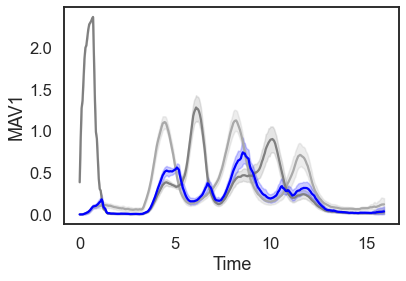

In [6]:
# try out what you can do with this data

# make a plot for the average MAV values for participant 1 in block 1
df_SN1 = df[df["SN"] == 1]
# df_SN1
df_SN1_BN1 = df_SN1[df_SN1["BN"] == 1]     

# plot the mean MAV1 and MAV2 for each timepoint
sns.lineplot(data=df_SN1_BN1, x="Time", y="MAV1", color='darkgrey')
sns.lineplot(data=df_SN1_BN1, x="Time", y="MAV2", color='grey')

# plot cocontraction
sns.lineplot(data=df_SN1_BN1, x="Time", y="Cocontraction", color='blue')



In [7]:
# try working with pivot tables

# make a table that puts the different trials for each block (for each participant) in a column
test = pd.pivot_table(df, values="Cocontraction", index=["SN", "BN", "Time"], columns="TN")
test

# if you want to caclulate the mean cocontraction for each noise level
test_with_mean = pd.pivot_table(df, values="Cocontraction", index=["SN", "BN", "Noise", "Time"], aggfunc={'Cocontraction': "mean"})
test_with_mean


Cocontraction
SN   BN  Noise Time                
1.0  1.0 0.0   0.00        0.000000
               0.05        0.000000
               0.10        0.000000
               0.15        0.000000
               0.20        0.000000
...                             ...
10.0 4.0 0.3   15.75       0.084430
               15.80       0.124934
               15.85       0.155588
               15.90       0.139214
               15.95       0.103822

[25600 rows x 1 columns]

<AxesSubplot:>

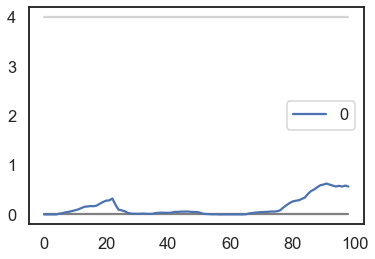

In [8]:
# plots to test things

sns.lineplot(data=data[1:100,5], color='lightgrey')
sns.lineplot(data=data[1:100,6], color='grey')
# sns.lineplot(data=inputlow[1:100], color='green')
# sns.lineplot(data=inputhigh[1:100], color='blue')
sns.lineplot(data=cocontraction[1:100], color='red')



